In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
matches_original = pd.read_csv('matches.csv', parse_dates=['date'])
matches_original.tail(2)

,date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore
34254,2006-07-08,GER,Germany,POR,Portugal,3-1,NaN,NaN,9741,FIFA World Cup™ Final,3,1,NaN,NaN
34255,2006-07-09,ITA,Italy,FRA,France,1-1 (5-3),Win on penalty,NaN,9741,FIFA World Cup™ Final,1,1,5.0,3.0


In [2]:
matches = matches_original.copy()
matches.drop_duplicates(['date', 'team1', 'team2'], inplace=True)
matches['team1Score'] = matches['team1Score'].astype('float64')
matches['team2Score'] = matches['team2Score'].astype('float64')
matches = matches.reset_index(drop=True)

In [3]:
matches.dtypes

date             datetime64[ns]
team1                    object
team1Text                object
team2                    object
team2Text                object
resText                  object
statText                 object
venue                    object
IdCupSeason               int64
CupName                  object
team1Score              float64
team2Score              float64
team1PenScore           float64
team2PenScore           float64
dtype: object

In [4]:
matches['match_id'] = matches.index + 1

In [5]:
matches.describe(include = 'all')

,date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore,match_id
count,33783,33783,33783,33783,33783,33783,648,28780,3.378300e+04,33783,33783.000000,33783.000000,465.000000,465.000000,33783.000000
unique,10967,224,235,222,233,227,5,2772,NaN,10,NaN,NaN,NaN,NaN,NaN
top,2008-03-26 00:00:00,KOR,Korea Republic,KOR,Korea Republic,1-0,Win on penalty,"Merdeka - Kuala Lumpur , Malaysia",NaN,Friendly,NaN,NaN,NaN,NaN,NaN
freq,65,566,566,397,397,3698,464,608,NaN,16807,NaN,NaN,NaN,NaN,NaN
first,1950-02-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-07-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.950465e+08,NaN,1.708552,1.095048,4.055914,3.782796,16892.000000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.999636e+08,NaN,1.669892,1.300685,1.633793,1.811757,9752.456409
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.881000e+03,NaN,1.000000,0.000000,3.000000,3.000000,8446.500000


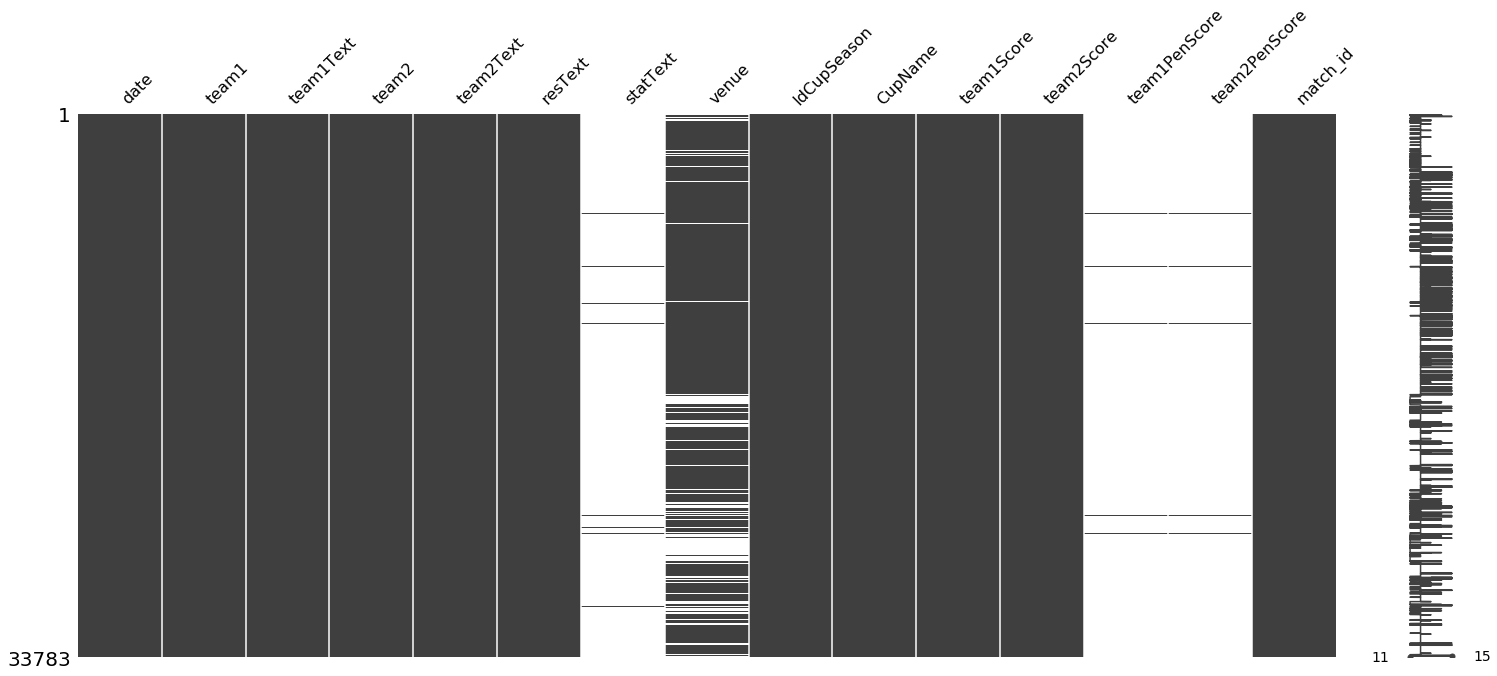

In [6]:
import missingno as msno
%matplotlib inline
msno.matrix(matches)

In [7]:
(matches['team1Score'] - matches['team2Score']).describe()

count    33783.000000
mean         0.613504
std          2.268090
min        -22.000000
25%         -1.000000
50%          1.000000
75%          2.000000
max         31.000000
dtype: float64

The Mean value for the goal differential is greater than 0.6, which may present a problem later on when training the model - it may capture this bias team1 is better than team2, which is something we'd rather avoid, especially since the World Cup final tournament is played in a single country.

So let's get rid of that by simply randomizing the order in which teams are listed for any one match.

In [8]:
import numpy as np
import rpy2.robjects as robjects

data = robjects.r("""
set.seed(4342)
x <- runif(33783, min = 0, max = 1)
""")

matches['switch'] = np.array(data)

# np.random.seed(4342)
# matches['switch'] = np.random.rand(matches.shape[0])

matches['x_team2'] = matches['team2']
matches['team2'] = np.where(matches['switch']>=.5, matches['team1'], matches['team2'])
matches['team1'] = np.where(matches['switch']>=.5, matches['x_team2'], matches['team1'])

matches['x_team2Text'] = matches['team2Text']
matches['team2Text'] = np.where(matches['switch']>=.5, matches['team1Text'], matches['team2Text'])
matches['team1Text'] = np.where(matches['switch']>=.5, matches['x_team2Text'], matches['team1Text'])

matches['x_team2Score'] = matches['team2Score']
matches['team2Score'] = np.where(matches['switch']>=.5, matches['team1Score'], matches['team2Score'])
matches['team1Score'] = np.where(matches['switch']>=.5, matches['x_team2Score'], matches['team1Score'])

matches['x_team2PenScore'] = matches['team2PenScore']
matches['team2PenScore'] = np.where(matches['switch']>=.5, matches['team1PenScore'], matches['team2PenScore'])
matches['team1PenScore'] = np.where(matches['switch']>=.5, matches['x_team2PenScore'], matches['team1PenScore'])

matches.drop(['switch', 'x_team2', 'x_team2Text', 'x_team2Score', 'x_team2PenScore'], axis=1, inplace=True)
matches.sort_values(['date'], ascending=[1], inplace=True)
(matches['team1Score'] - matches['team2Score']).describe()

/home/terry/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/terry/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/terry/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/home/terry/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/terry/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/home/terry/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWarning)
/home/terry/anaconda3/lib/python3.6/site-packages/rpy2/rinterface

count    33783.000000
mean        -0.009117
std          2.349585
min        -31.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max         18.000000
dtype: float64

In [9]:
matches['team1Home'] = matches.apply(lambda row: str(row.venue).find(row.team1Text) != -1, axis=1)
matches['team2Home'] = matches.apply(lambda row: str(row.venue).find(row.team2Text) != -1, axis=1)
matches['neutralVenue'] = ~(matches['team1Home'] | matches['team2Home'])

In [10]:
# text-matching the venue is not 100% accurate.
# some games get TRUE for both team1 and team2 (ex. Congo DR vs Congo)
matches[matches['team1Home'] & matches['team2Home']]

,date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore,match_id,team1Home,team2Home,neutralVenue
6911,1987-06-12,USA,USA,KOR,Korea Republic,1-0,NaN,"BUSAN - Busan , Korea Republic",2000010101,Friendly,0.0,1.0,NaN,NaN,6912,True,True,False
33329,1996-06-01,GUI,Guinea,GNB,Guinea-Bissau,3-2,NaN,"Stade du 24 septembre - Bissau , Guinea-Bissau",894,FIFA World Cup™ Qualifier,2.0,3.0,NaN,NaN,33330,True,True,False
10583,1999-10-30,COD,Congo DR,CGO,Congo,1-1,NaN,"KINSHASA - Kinshasa , Congo DR",2000010101,Friendly,1.0,1.0,NaN,NaN,10584,True,True,False
28467,2000-07-09,CGO,Congo,COD,Congo DR,2-0,NaN,"Stade de Martyrs - Kinshasa , Congo DR",3868,FIFA World Cup™ Qualifier,0.0,2.0,NaN,NaN,28468,True,True,False
11902,2003-03-09,CGO,Congo,COD,Congo DR,3-0,NaN,"KINSHASA - Kinshasa , Congo DR",2000010101,Friendly,0.0,3.0,NaN,NaN,11903,True,True,False
18921,2006-09-02,NGA,Nigeria,NIG,Niger,2-0,NaN,"National Stadium - Abuja , Nigeria",247868,Continental Qualifier,2.0,0.0,NaN,NaN,18922,True,True,False
20924,2010-10-17,DMA,Dominica,DOM,Dominican Republic,0-1,NaN,"Estadio Panamericano - San Cristobal , Dominic...",255525,Continental Qualifier,1.0,0.0,NaN,NaN,20925,True,True,False
16201,2013-07-07,COD,Congo DR,CGO,Congo,2-1,NaN,"Stade de Martyrs - Kinshasa , Congo DR",2000010101,Friendly,2.0,1.0,NaN,NaN,16202,True,True,False
17136,2015-09-08,NIG,Niger,NGA,Nigeria,2-0,NaN,"Adokiye Amiesimaka Stadium - Port Harcourt , N...",2000010101,Friendly,0.0,2.0,NaN,NaN,17137,True,True,False


In [11]:
# in this case, team1 is at home
matches.loc[matches['team1Home']&matches['team2Home'],'team2Home'] = False

In [12]:
matches['friendly'] = matches['CupName'] == 'Friendly'
matches['qualifier'] = matches['CupName'].str.contains('Qual')
matches['finaltourn'] = matches['CupName'].str.contains('Final') | matches['CupName'].str.contains('Confederations Cup')

In [13]:
# At this point, we're going to eliminate friendly matches from the dataset.
# This decision is based on the observation that, with few exceptions, the main objective for a team playing a friendly is not to win it, but to evaluate its own players and tactics.
# For this reason it's not uncommon for friendlies to allow an unlimited number of substitutions, and for a team to roll out its entire squad during a friendly game.
matches = matches[matches['friendly'] == False]

In [14]:
countryCodeMappings = {'FRG':'GER',
                       'TCH':'CZE',
                       'URS':'RUS',
                       'SCG':'SRB',
                       'ZAI':'COD'}
                                         
matches.replace({'team1': countryCodeMappings,
                 'team2': countryCodeMappings}, inplace=True)

In [15]:
tmp1 = matches.copy()
tmp1.rename(index=str, columns={'team1':'name',
                                'team2':'opponentName',
                                'team1Home':'homeVenue',
                                'team1Score':'gs',
                                'team2Score':'ga'}, inplace=True)
tmp1['w'] = tmp1['gs'] > tmp1['ga']
tmp1['l'] = tmp1['gs'] < tmp1['ga']
tmp1['d'] = tmp1['gs'] == tmp1['ga']
tmp1['gd'] = tmp1['gs'] - tmp1['ga']
tmp1 = tmp1[['match_id', 'date', 'name', 'opponentName', 'homeVenue', 'neutralVenue', 'gs', 'ga', 'gd', 'w', 'l', 'd', 'friendly', 'qualifier', 'finaltourn']]

tmp2 = matches.copy()
tmp2.rename(index=str, columns={'team2':'name',
                                'team1':'opponentName',
                                'team2Home':'homeVenue',
                                'team2Score':'gs',
                                'team1Score':'ga'}, inplace=True)
tmp2['w'] = tmp2['gs'] > tmp2['ga']
tmp2['l'] = tmp2['gs'] < tmp2['ga']
tmp2['d'] = tmp2['gs'] == tmp2['ga']
tmp2['gd'] = tmp2['gs'] - tmp2['ga']
tmp2 = tmp2[['match_id', 'date', 'name', 'opponentName', 'homeVenue', 'neutralVenue', 'gs', 'ga', 'gd', 'w', 'l', 'd', 'friendly', 'qualifier', 'finaltourn']]

teamperf = pd.concat([tmp1, tmp2])

In [16]:
# get rid of all the outliers
teamperf.loc[teamperf['gd'] < -7, 'gd'] = -7
teamperf.loc[teamperf['gd'] >  7, 'gd'] =  7

In [17]:
teams = pd.read_csv('teams.csv')
teamperf = teamperf.merge(teams[['fifa_code','confederation']], how='left', left_on='opponentName', right_on='fifa_code', copy=False)
# to fix: created duplicated rows as fifa_code is not unique
teamperf.drop(labels=['fifa_code'], axis=1, inplace=True)

confederations = pd.DataFrame(data=[['UEFA', 0.99],
                                    ['CONMEBOL', 1.00],
                                    ['CONCACAF', 0.85],
                                    ['AFC', 0.85],
                                    ['CAF', 0.85],
                                    ['OFC', 0.85]], columns=['confederation','adjust'])
teamperf = teamperf.merge(confederations, how='left', on='confederation', copy=False)
teamperf.rename(index=str, columns={'adjust':'opponentConfederationCoefficient'}, inplace=True)
teamperf.opponentConfederationCoefficient.fillna(1, inplace=True)

In [18]:
teamperf.sort_values(['name', 'date'], inplace=True)
teamperf['last10games_w_per'] = (teamperf.groupby('name')['w'].apply(lambda x: x.rolling(10, min_periods=1).sum().shift())/10).fillna(0)
teamperf['last30games_w_per'] = (teamperf.groupby('name')['w'].apply(lambda x: x.rolling(30, min_periods=1).sum().shift())/30).fillna(0)
teamperf['last50games_w_per'] = (teamperf.groupby('name')['w'].apply(lambda x: x.rolling(50, min_periods=1).sum().shift())/50).fillna(0)
teamperf['last10games_l_per'] = (teamperf.groupby('name')['l'].apply(lambda x: x.rolling(10, min_periods=1).sum().shift())/10).fillna(0)
teamperf['last30games_l_per'] = (teamperf.groupby('name')['l'].apply(lambda x: x.rolling(30, min_periods=1).sum().shift())/30).fillna(0)
teamperf['last50games_l_per'] = (teamperf.groupby('name')['l'].apply(lambda x: x.rolling(50, min_periods=1).sum().shift())/50).fillna(0)
teamperf['last10games_d_per'] = (teamperf.groupby('name')['d'].apply(lambda x: x.rolling(10, min_periods=1).sum().shift())/10).fillna(0)
teamperf['last30games_d_per'] = (teamperf.groupby('name')['d'].apply(lambda x: x.rolling(30, min_periods=1).sum().shift())/30).fillna(0)
teamperf['last50games_d_per'] = (teamperf.groupby('name')['d'].apply(lambda x: x.rolling(50, min_periods=1).sum().shift())/50).fillna(0)
teamperf['last10games_gd_per'] = (teamperf.groupby('name')['gd'].apply(lambda x: x.rolling(10, min_periods=1).sum().shift())/10).fillna(0)
teamperf['last30games_gd_per'] = (teamperf.groupby('name')['gd'].apply(lambda x: x.rolling(30, min_periods=1).sum().shift())/30).fillna(0)
teamperf['last50games_gd_per'] = (teamperf.groupby('name')['gd'].apply(lambda x: x.rolling(50, min_periods=1).sum().shift())/50).fillna(0)
teamperf['last10games_opp_cc_per'] = (teamperf.groupby('name')['opponentConfederationCoefficient'].apply(lambda x: x.rolling(10, min_periods=1).sum().shift())/10).fillna(0)
teamperf['last30games_opp_cc_per'] = (teamperf.groupby('name')['opponentConfederationCoefficient'].apply(lambda x: x.rolling(30, min_periods=1).sum().shift())/30).fillna(0)
teamperf['last50games_opp_cc_per'] = (teamperf.groupby('name')['opponentConfederationCoefficient'].apply(lambda x: x.rolling(50, min_periods=1).sum().shift())/50).fillna(0)

In [19]:
team_features = teamperf.copy()
team_features.drop(['homeVenue', 'neutralVenue', 'friendly', 'qualifier', 'finaltourn', 'confederation'], axis=1, inplace=True)
team_features.head()

,match_id,date,name,opponentName,gs,ga,gd,w,l,d,opponentConfederationCoefficient,last10games_w_per,last30games_w_per,last50games_w_per,last10games_l_per,last30games_l_per,last50games_l_per,last10games_d_per,last30games_d_per,last50games_d_per,last10games_gd_per,last30games_gd_per,last50games_gd_per,last10games_opp_cc_per,last30games_opp_cc_per,last50games_opp_cc_per
19132,18181,1975-04-02,AFG,KSA,0.0,2.0,-2.0,False,True,False,0.85,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.000,0.000000,0.000
19136,18182,1975-04-04,AFG,IRQ,0.0,4.0,-4.0,False,True,False,0.85,0.0,0.0,0.0,0.1,0.033333,0.02,0.0,0.0,0.0,-0.2,-0.066667,-0.04,0.085,0.028333,0.017
2040,18185,1975-04-06,AFG,QAT,1.0,2.0,-1.0,False,True,False,0.85,0.0,0.0,0.0,0.2,0.066667,0.04,0.0,0.0,0.0,-0.6,-0.200000,-0.12,0.170,0.056667,0.034
2042,18187,1975-04-10,AFG,KSA,0.0,6.0,-6.0,False,True,False,0.85,0.0,0.0,0.0,0.3,0.100000,0.06,0.0,0.0,0.0,-0.7,-0.233333,-0.14,0.255,0.085000,0.051
19143,18189,1975-04-12,AFG,QAT,1.0,1.0,0.0,False,False,True,0.85,0.0,0.0,0.0,0.4,0.133333,0.08,0.0,0.0,0.0,-1.3,-0.433333,-0.26,0.340,0.113333,0.068


In [20]:
match_features = matches.drop(['team1Text', 'team2Text', 'resText', 'statText', 'venue', 'IdCupSeason', 'CupName', 
                               'team1Score', 'team2Score', 
                               'team1PenScore', 
                               'team2PenScore'], axis=1).merge(team_features.drop(['date', 'opponentName', 
                                                                                   'gs', 'ga', 'w', 'l', 'd', 
                                                                                   'opponentConfederationCoefficient'], axis=1), how='left', left_on=['match_id', 
                                                                                                                                                      'team1'], right_on=['match_id', 'name']).drop(['name'], axis=1)
match_features = match_features.merge(team_features.drop(['date', 'opponentName', 'gs', 'ga', 'gd', 'w', 'l', 'd', 
                                                          'opponentConfederationCoefficient'], axis=1), how='left', left_on=['match_id', 
                                                                                                                             'team2'], right_on=['match_id', 
                                                                                                                                                 'name'], suffixes=('_t1', '_t2')).drop(['match_id', 'name'], axis=1)
match_features.rename(index=str, columns={'gd':'outcome'}, inplace=True)
print(match_features.shape)
match_features.tail()

(17215, 40)


,date,team1,team2,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn,outcome,last10games_w_per_t1,last30games_w_per_t1,last50games_w_per_t1,last10games_l_per_t1,last30games_l_per_t1,last50games_l_per_t1,last10games_d_per_t1,last30games_d_per_t1,last50games_d_per_t1,last10games_gd_per_t1,last30games_gd_per_t1,last50games_gd_per_t1,last10games_opp_cc_per_t1,last30games_opp_cc_per_t1,last50games_opp_cc_per_t1,last10games_w_per_t2,last30games_w_per_t2,last50games_w_per_t2,last10games_l_per_t2,last30games_l_per_t2,last50games_l_per_t2,last10games_d_per_t2,last30games_d_per_t2,last50games_d_per_t2,last10games_gd_per_t2,last30games_gd_per_t2,last50games_gd_per_t2,last10games_opp_cc_per_t2,last30games_opp_cc_per_t2,last50games_opp_cc_per_t2
17210,2016-07-02,GER,ITA,False,False,True,False,False,True,0.0,0.7,0.766667,0.82,0.1,0.100000,0.10,0.2,0.133333,0.08,1.1,1.633333,1.76,0.990,0.976667,0.9796,0.7,0.600000,0.56,0.1,0.133333,0.12,0.2,0.266667,0.32,0.9,0.666667,0.70,0.990,0.977000,0.9796
17211,2016-07-03,FRA,ISL,True,False,False,False,False,True,3.0,0.7,0.566667,0.52,0.1,0.166667,0.22,0.2,0.266667,0.26,1.4,0.900000,0.64,0.963,0.981000,0.9792,0.5,0.466667,0.32,0.1,0.300000,0.44,0.4,0.233333,0.24,0.6,0.300000,-0.28,0.990,0.990000,0.9900
17212,2016-07-06,WAL,POR,False,False,True,False,False,True,-2.0,0.7,0.533333,0.44,0.2,0.333333,0.42,0.1,0.133333,0.14,0.8,0.100000,-0.10,0.990,0.990000,0.9900,0.6,0.600000,0.60,0.0,0.100000,0.14,0.4,0.300000,0.26,0.6,0.600000,0.88,0.990,0.980667,0.9790
17213,2016-07-07,GER,FRA,False,True,False,False,False,True,-2.0,0.7,0.766667,0.82,0.1,0.066667,0.08,0.2,0.166667,0.10,1.1,1.666667,1.78,0.990,0.976667,0.9796,0.7,0.566667,0.54,0.1,0.166667,0.20,0.2,0.266667,0.26,1.4,0.933333,0.76,0.963,0.981000,0.9792
17214,2016-07-10,FRA,POR,True,False,False,False,False,True,-1.0,0.7,0.566667,0.56,0.1,0.166667,0.18,0.2,0.266667,0.26,1.3,0.933333,0.84,0.977,0.981000,0.9792,0.6,0.600000,0.60,0.0,0.100000,0.14,0.4,0.300000,0.26,0.7,0.633333,0.84,0.990,0.980667,0.9790


In [21]:
import datetime
data_train1 = match_features[match_features.date < datetime.datetime(2009,1,1)]
print(data_train1.shape)
data_test1 = match_features[(match_features.date >= datetime.datetime(2009,1,1)).values & (match_features.date <= datetime.datetime(2015,1,1)).values]
print(data_test1.shape)

(13979, 40)
(2432, 40)


In [22]:
X_train = data_train1.drop(['date', 'team1', 'team2', 'outcome'], axis=1)
print(X_train.shape)
y_train = data_train1['outcome']
print(y_train.shape)
type(y_train)

(13979, 36)
(13979,)


pandas.core.series.Series

In [23]:
data_train1[['team1','outcome']].groupby('outcome').count()

,team1
outcome,
-7.0,201
-6.0,120
-5.0,240
-4.0,384
-3.0,846
-2.0,1410
-1.0,2268
0.0,2983
1.0,2308


In [24]:
X_test = data_test1.drop(['date', 'team1', 'team2', 'outcome'], axis=1)
print(X_test.shape)
y_test = data_test1['outcome']
print(y_test.shape)
type(y_test)

(2432, 36)
(2432,)


pandas.core.series.Series

In [25]:
# import xgboost as xgb

# params = {
#         'eta': 0.03333,
#         'max_depth': 4,
#         'objective': 'multi:softprob',
#         'eval_metric': 'mlogloss',
#         'num_class': 9,
#         'seed': 42,
#         'silent': True,
#         'tree_method': 'gpu_hist'
#     }

# # x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
# watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]
# model = xgb.train(params, xgb.DMatrix(X_train, y_train), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
# score1 = metrics.log_loss(y_test, model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit), labels = list(range(9)))

# # # read in data
# # dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
# # dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# # # specify parameters via map
# # param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
# # num_round = 2
# # bst = xgb.train(param, dtrain, num_round)
# # # make prediction
# # preds = bst.predict(dtest)

In [26]:
from sklearn.ensemble import RandomForestRegressor
randomForest1 = RandomForestRegressor(n_estimators=500)
randomForest1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Feature ranking:
1. feature 22 (0.080534)
2. feature 32 (0.079220)
3. feature 17 (0.073728)
4. feature 15 (0.058802)
5. feature 30 (0.057687)
6. feature 7 (0.056571)
7. feature 16 (0.053758)
8. feature 8 (0.046799)
9. feature 31 (0.044150)
10. feature 1 (0.029543)
11. feature 35 (0.028281)
12. feature 20 (0.026062)
13. feature 0 (0.025392)
14. feature 23 (0.025362)
15. feature 34 (0.023533)
16. feature 19 (0.022906)
17. feature 29 (0.020392)
18. feature 14 (0.020154)
19. feature 11 (0.019211)
20. feature 26 (0.019193)
21. feature 13 (0.018654)
22. feature 18 (0.017562)
23. feature 28 (0.017022)
24. feature 33 (0.016837)
25. feature 25 (0.016312)
26. feature 10 (0.015914)
27. feature 27 (0.013465)
28. feature 12 (0.013191)
29. feature 21 (0.012702)
30. feature 24 (0.012557)
31. feature 6 (0.012243)
32. feature 9 (0.011945)
33. feature 2 (0.006074)
34. feature 4 (0.002171)
35. feature 5 (0.002071)
36. feature 3 (0.000000)


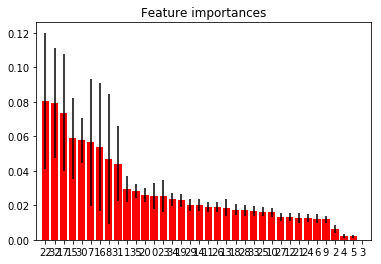

In [27]:
importances = randomForest1.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

import matplotlib.pyplot as plt
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [28]:
randomForest1_pred = randomForest1.predict(X_test)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, randomForest1_pred))

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, randomForest1_pred))
print(rms)

1.3099498355263157
1.7186867332853457


In [29]:
qualified = pd.read_csv('wc2018qualified.csv')
qualified

,name,draw
0,RUS,A1
1,KSA,A2
2,EGY,A3
3,URU,A4
4,POR,B1
5,ESP,B2
6,MAR,B3
7,IRN,B4
8,FRA,C1
9,AUS,C2


In [30]:
# import numpy as np
topredict = np.array([(x, y) for x in qualified['name'] for y in qualified['name']])
topredict = pd.DataFrame(topredict, columns=['team1', 'team2'])
topredict = topredict[topredict['team1'] < topredict['team2']]
# topredict.sort_values('team2', inplace=True)
print(topredict.shape)
temp = teamperf[['name', 'date']].groupby('name').max().join(qualified.set_index('name'), how='inner').drop('draw', axis=1).reset_index()
temp = team_features.merge(temp, how='inner', on=['name', 'date'])
temp.drop(['match_id', 'date', 'opponentName', 'gs', 'ga', 'gd', 'w', 'l', 'd', 'opponentConfederationCoefficient'], axis=1, inplace=True)
topredict = topredict.merge(temp, how='left', left_on='team1', right_on='name')
topredict.drop(['name'], axis=1, inplace=True)
topredict = topredict.merge(temp, how='left', left_on='team2', right_on='name', suffixes=('_t1', '_t2'))
topredict.drop(['name'], axis=1, inplace=True)
print(topredict.shape)
topredict.tail()

(496, 2)
(496, 32)


,team1,team2,last10games_w_per_t1,last30games_w_per_t1,last50games_w_per_t1,last10games_l_per_t1,last30games_l_per_t1,last50games_l_per_t1,last10games_d_per_t1,last30games_d_per_t1,last50games_d_per_t1,last10games_gd_per_t1,last30games_gd_per_t1,last50games_gd_per_t1,last10games_opp_cc_per_t1,last30games_opp_cc_per_t1,last50games_opp_cc_per_t1,last10games_w_per_t2,last30games_w_per_t2,last50games_w_per_t2,last10games_l_per_t2,last30games_l_per_t2,last50games_l_per_t2,last10games_d_per_t2,last30games_d_per_t2,last50games_d_per_t2,last10games_gd_per_t2,last30games_gd_per_t2,last50games_gd_per_t2,last10games_opp_cc_per_t2,last30games_opp_cc_per_t2,last50games_opp_cc_per_t2
491,JPN,KOR,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.6,0.533333,0.50,0.3,0.233333,0.18,0.1,0.233333,0.32,1.8,1.133333,0.92,0.878,0.879,0.876
492,JPN,PAN,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.3,0.300000,0.38,0.3,0.266667,0.24,0.4,0.433333,0.38,-0.3,0.066667,0.42,0.880,0.860,0.856
493,JPN,TUN,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.6,0.500000,0.52,0.1,0.166667,0.20,0.3,0.333333,0.28,1.1,0.700000,0.78,0.850,0.850,0.850
494,JPN,POL,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.5,0.333333,0.40,0.1,0.266667,0.26,0.4,0.400000,0.34,0.9,0.566667,0.58,0.990,0.990,0.990
495,JPN,SEN,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.7,0.533333,0.48,0.1,0.166667,0.20,0.2,0.300000,0.32,1.3,0.700000,0.76,0.850,0.860,0.856


In [31]:
topredict['date'] = datetime.datetime(2018,6,14)
topredict['team1Home'] = topredict['team1'] == 'RUS'
topredict['team2Home'] = topredict['team2'] == 'RUS'
topredict['neutralVenue'] = ~(topredict['team1Home'] | topredict['team2Home'])
topredict['friendly'] = False
topredict['qualifier'] = False
topredict['finaltourn'] = True
print(topredict.shape)
topredict.tail()

(496, 39)


,team1,team2,last10games_w_per_t1,last30games_w_per_t1,last50games_w_per_t1,last10games_l_per_t1,last30games_l_per_t1,last50games_l_per_t1,last10games_d_per_t1,last30games_d_per_t1,last50games_d_per_t1,last10games_gd_per_t1,last30games_gd_per_t1,last50games_gd_per_t1,last10games_opp_cc_per_t1,last30games_opp_cc_per_t1,last50games_opp_cc_per_t1,last10games_w_per_t2,last30games_w_per_t2,last50games_w_per_t2,last10games_l_per_t2,last30games_l_per_t2,last50games_l_per_t2,last10games_d_per_t2,last30games_d_per_t2,last50games_d_per_t2,last10games_gd_per_t2,last30games_gd_per_t2,last50games_gd_per_t2,last10games_opp_cc_per_t2,last30games_opp_cc_per_t2,last50games_opp_cc_per_t2,date,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn
491,JPN,KOR,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.6,0.533333,0.50,0.3,0.233333,0.18,0.1,0.233333,0.32,1.8,1.133333,0.92,0.878,0.879,0.876,2018-06-14,False,False,True,False,False,True
492,JPN,PAN,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.3,0.300000,0.38,0.3,0.266667,0.24,0.4,0.433333,0.38,-0.3,0.066667,0.42,0.880,0.860,0.856,2018-06-14,False,False,True,False,False,True
493,JPN,TUN,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.6,0.500000,0.52,0.1,0.166667,0.20,0.3,0.333333,0.28,1.1,0.700000,0.78,0.850,0.850,0.850,2018-06-14,False,False,True,False,False,True
494,JPN,POL,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.5,0.333333,0.40,0.1,0.266667,0.26,0.4,0.400000,0.34,0.9,0.566667,0.58,0.990,0.990,0.990,2018-06-14,False,False,True,False,False,True
495,JPN,SEN,0.6,0.466667,0.5,0.2,0.3,0.26,0.2,0.233333,0.24,1.8,0.8,1.04,0.879,0.874,0.873,0.7,0.533333,0.48,0.1,0.166667,0.20,0.2,0.300000,0.32,1.3,0.700000,0.76,0.850,0.860,0.856,2018-06-14,False,False,True,False,False,True


In [32]:
X_test.tail()

,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn,last10games_w_per_t1,last30games_w_per_t1,last50games_w_per_t1,last10games_l_per_t1,last30games_l_per_t1,last50games_l_per_t1,last10games_d_per_t1,last30games_d_per_t1,last50games_d_per_t1,last10games_gd_per_t1,last30games_gd_per_t1,last50games_gd_per_t1,last10games_opp_cc_per_t1,last30games_opp_cc_per_t1,last50games_opp_cc_per_t1,last10games_w_per_t2,last30games_w_per_t2,last50games_w_per_t2,last10games_l_per_t2,last30games_l_per_t2,last50games_l_per_t2,last10games_d_per_t2,last30games_d_per_t2,last50games_d_per_t2,last10games_gd_per_t2,last30games_gd_per_t2,last50games_gd_per_t2,last10games_opp_cc_per_t2,last30games_opp_cc_per_t2,last50games_opp_cc_per_t2
16406,False,True,False,False,True,False,0.3,0.300000,0.28,0.5,0.366667,0.44,0.2,0.333333,0.28,-0.6,-0.300000,-0.50,0.850,0.850000,0.8500,0.2,0.433333,0.40,0.5,0.400000,0.36,0.3,0.166667,0.24,-0.3,0.733333,0.46,0.850,0.850000,0.8500
16407,False,True,False,False,True,False,0.2,0.366667,0.42,0.4,0.366667,0.28,0.4,0.266667,0.30,-0.1,0.266667,0.42,0.850,0.850000,0.8528,0.7,0.633333,0.52,0.2,0.233333,0.36,0.1,0.133333,0.12,0.7,0.800000,0.32,0.850,0.850000,0.8500
16408,True,False,False,False,True,False,0.5,0.666667,0.64,0.4,0.200000,0.18,0.1,0.133333,0.18,0.3,1.200000,1.18,0.879,0.864667,0.8674,0.5,0.533333,0.56,0.3,0.300000,0.24,0.2,0.166667,0.20,0.3,0.500000,0.64,0.879,0.869000,0.8672
16409,True,False,False,False,True,False,0.4,0.466667,0.44,0.4,0.300000,0.34,0.2,0.233333,0.22,0.2,0.433333,0.36,0.850,0.850000,0.8500,0.7,0.600000,0.56,0.2,0.266667,0.28,0.1,0.133333,0.16,1.0,0.666667,0.54,0.892,0.873333,0.8640
16410,False,True,False,False,True,False,0.3,0.166667,0.16,0.4,0.566667,0.56,0.3,0.266667,0.28,-0.3,-1.166667,-1.14,0.850,0.850000,0.8500,0.3,0.366667,0.34,0.3,0.333333,0.36,0.4,0.300000,0.30,0.3,0.100000,0.10,0.850,0.854667,0.8528


In [33]:
prediction = topredict.copy()
prediction['outcome_pred'] = randomForest1.predict(topredict.drop(['date', 'team1', 'team2'], axis=1))
print(prediction.shape)
prediction[prediction.team1=='KSA']

(496, 40)


,team1,team2,last10games_w_per_t1,last30games_w_per_t1,last50games_w_per_t1,last10games_l_per_t1,last30games_l_per_t1,last50games_l_per_t1,last10games_d_per_t1,last30games_d_per_t1,last50games_d_per_t1,last10games_gd_per_t1,last30games_gd_per_t1,last50games_gd_per_t1,last10games_opp_cc_per_t1,last30games_opp_cc_per_t1,last50games_opp_cc_per_t1,last10games_w_per_t2,last30games_w_per_t2,last50games_w_per_t2,last10games_l_per_t2,last30games_l_per_t2,last50games_l_per_t2,last10games_d_per_t2,last30games_d_per_t2,last50games_d_per_t2,last10games_gd_per_t2,last30games_gd_per_t2,last50games_gd_per_t2,last10games_opp_cc_per_t2,last30games_opp_cc_per_t2,last50games_opp_cc_per_t2,date,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn,outcome_pred
6,KSA,RUS,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.4,0.500000,0.56,0.3,0.233333,0.24,0.3,0.266667,0.20,0.8,1.166667,1.02,0.990,0.980667,0.9844,2018-06-14,False,True,False,False,False,True,1.220
7,KSA,URU,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.4,0.466667,0.42,0.4,0.366667,0.36,0.2,0.166667,0.22,0.4,0.500000,0.30,0.985,0.963667,0.9688,2018-06-14,False,False,True,False,False,True,0.310
8,KSA,POR,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.6,0.600000,0.60,0.0,0.100000,0.14,0.4,0.300000,0.26,0.7,0.633333,0.84,0.990,0.980667,0.9790,2018-06-14,False,False,True,False,False,True,-0.670
9,KSA,MAR,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.7,0.400000,0.50,0.2,0.266667,0.22,0.1,0.333333,0.28,0.9,0.466667,0.70,0.850,0.854667,0.8528,2018-06-14,False,False,True,False,False,True,-0.644
10,KSA,PER,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.4,0.300000,0.32,0.4,0.500000,0.52,0.2,0.200000,0.16,-0.2,-0.400000,-0.48,0.985,0.995000,0.9940,2018-06-14,False,False,True,False,False,True,0.142
11,KSA,NGA,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.3,0.466667,0.46,0.2,0.200000,0.20,0.5,0.333333,0.34,0.4,0.700000,0.70,0.850,0.874000,0.8732,2018-06-14,False,False,True,False,False,True,-0.638
12,KSA,SUI,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.7,0.566667,0.54,0.1,0.233333,0.24,0.2,0.200000,0.22,1.6,0.866667,0.76,0.990,0.972000,0.9766,2018-06-14,False,False,True,False,False,True,0.262
13,KSA,SRB,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.4,0.366667,0.40,0.4,0.433333,0.34,0.2,0.200000,0.26,0.5,0.233333,0.46,0.990,0.976000,0.9734,2018-06-14,False,False,True,False,False,True,0.342
14,KSA,SWE,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.5,0.466667,0.52,0.3,0.300000,0.28,0.2,0.233333,0.20,0.4,0.333333,0.70,0.990,0.990000,0.9900,2018-06-14,False,False,True,False,False,True,0.114
15,KSA,MEX,0.8,0.5,0.54,0.0,0.2,0.18,0.2,0.3,0.28,2.2,0.866667,0.86,0.88,0.86,0.856,0.8,0.566667,0.56,0.0,0.200000,0.18,0.2,0.233333,0.26,1.7,1.000000,0.92,0.880,0.889333,0.8852,2018-06-14,False,False,True,False,False,True,0.084


In [34]:
prediction['outcome_pred'].unique()

array([ 1.732 ,  1.49  ,  1.572 ,  1.33  ,  0.318 ,  0.228 ,  1.22  ,
        0.31  , -0.67  , -0.644 ,  0.142 , -0.638 ,  0.262 ,  0.342 ,
        0.114 ,  0.084 , -0.536 , -0.73  , -0.388 , -0.612 ,  0.07  ,
       -0.978 , -0.328 , -0.886 , -0.234 , -0.934 , -0.908 , -0.874 ,
       -0.278 , -0.49  , -1.03  , -0.386 , -0.272 , -0.432 , -0.366 ,
       -0.528 , -1.032 , -1.01  , -1.06  , -1.132 , -1.118 , -0.428 ,
       -0.082 , -0.288 , -0.178 , -0.346 , -0.286 , -1.016 , -0.92  ,
       -1.6592, -0.936 , -1.8552, -1.558 , -1.688 , -1.546 , -1.034 ,
       -1.212 , -1.806 , -0.84  , -0.946 , -1.0072, -1.02  , -1.75  ,
       -1.726 , -1.748 , -1.728 , -0.916 ,  1.384 ,  0.422 , -0.696 ,
        0.23  , -0.616 ,  0.496 ,  0.174 ,  0.066 , -0.436 , -0.32  ,
       -0.62  , -0.508 , -1.5092, -0.37  , -1.6352, -1.354 , -0.426 ,
       -0.544 , -1.552 , -0.348 , -0.478 , -0.456 , -0.5512, -0.636 ,
       -1.63  , -1.556 , -1.458 , -1.526 , -0.074 , -1.0212, -0.3   ,
       -1.1032, -0.8